In [4]:
import pypsa
import pandas as pd
import pypsa
import numpy as np
import os
import matplotlib.pyplot as plt
import glob


run_name = "Demand_Sweep_24step_64n4h"
csvdir = 'results/'+run_name+'/csvs/'
outdir = "postanalysis/"
figdir = csvdir+outdir
SELECT_RUNS = False
RUNS = ["noscaling","transportsweep"]




In [5]:
# First, just mess around with csvs


def load_data(file):
    csvdir = 'results/'+run_name+'/csvs/'
    data = pd.read_csv(csvdir+file+'.csv',skiprows=lambda x: x in [0,1,2,4])
    data.set_index(list(data.columns[(np.arange(1+sum(["Unnamed" in c for c in list(data.columns)])))]),inplace=True)
    if SELECT_RUNS:
        data = data[[c for c in data.columns if any(n in c for n in RUNS)]]
    return data

def normalize_csv(file):
    #csvdir = 'results/'+run_name+'/csvs/'
    #outdir = "postanalysis/"

    data = pd.read_csv(csvdir+file+'.csv',skiprows=lambda x: x in [0,1,2,4])
    data.set_index(list(data.columns[(np.arange(1+sum(["Unnamed" in c for c in list(data.columns)])))]),inplace=True)
    datanorm = data.divide(data['noscaling'],axis=0)
    if not os.path.exists(os.getcwd()+'/'+csvdir+outdir):
        os.mkdir(os.getcwd()+'/'+csvdir+outdir)
    datanorm.to_csv(csvdir+outdir+file+'_normalized.csv',float_format="%.4f")
    
def aggregate_heat(df,heat_sources):
    #df 
    #heat_sources = ['air heat pump','resistive heater','ground heat pump']
    for s in heat_sources:
        inds = [i for i in df.index if s in i]
        df = pd.concat([df,pd.DataFrame({s : df.loc[inds].sum() }).T],axis=0)
        df = df.drop(inds)
    return df

In [6]:
# Save files with the following csvs, normalized to noscaling scenario

normalize_csv("supply")
normalize_csv("capacities")
normalize_csv("energy")
normalize_csv("costs")
normalize_csv("prices")

KeyError: 'noscaling'

In [ ]:
# Aggregate and print total costs

#simple approach
c=load_data("costs")
totc=pd.DataFrame(c.sum())
totc["ratio"] = totc.divide(totc.loc["noscaling"][0],axis=0)
totc.columns = ['total','ratio']
totc.to_csv(csvdir+outdir+"total_costs.csv")

# look at specific sources of costs
neg_costs = c.loc[[i for i in c.index if c.loc[i]["noscaling"]<0]]
#neg_costs = np.round(neg_costs/1e3)

neg_costs.sum()/totc['total']*100

csvdir+outdir+"total_costs.csv"


In [ ]:
# display primary energy use
supplygen = load_data("supply_energy").xs('generators', level=1, drop_level=True)
supplygen = supplygen.droplevel("scale")

supplystore = load_data("supply_energy").xs('stores', level=1, drop_level=True)
supplystore = supplystore.droplevel("scale")
supplystore.index = supplystore.index+" from store"
#drop non energy stores
supplystore = supplystore.loc[[i for i in supplystore.index if not ("co2" in i or "water tank" in i)]]
# keep only non cyclical stores
supplystore = supplystore.loc[[i for i in supplystore.index if abs(supplystore.sum(axis=1)[i])>1]]

supply = pd.concat([supplygen,supplystore],axis=0)

# aggregate solar thermal
st_inds = [i for i in supply.index if "solar thermal" in i]
supply = pd.concat([supply,pd.DataFrame({"solar thermal" : supply.loc[st_inds].sum() }).T],axis=0)
supply = supply.drop(st_inds)
supply.to_csv(csvdir+outdir+"primary_energy.csv") 
supplynorm = supply.divide(supply["noscaling"],axis=0)

supply

In [ ]:
def get_tfec():
    loads = load_data("energy")
    loads_energy = loads.loc['loads']
    loads_energy = loads_energy.loc[[i for i in loads_energy.index if not "emissions" in i]].sum()*-1
    tfec = pd.DataFrame(index=loads_energy.index)
    tfec['total'] = loads_energy/loads_energy['noscaling']
    tfec['all'] = loads_energy
    tfec = tfec.T
    return tfec

tfec = get_tfec()

In [ ]:
loads = load_data("supply_energy")
loads_supplynrg = loads.loc[:,"loads",:].droplevel(0)
loads_supplynrg = loads_supplynrg.loc[[i for i in loads_supplynrg.index if not "emissions" in i]].sum()*-1
loads_supplynrg
#loads_energy = loads.loc['loads']
#loads_energy = loads_energy.loc[[i for i in loads_energy.index if not "emissions" in i]].sum()*-1
#loads_energy

# TFEC

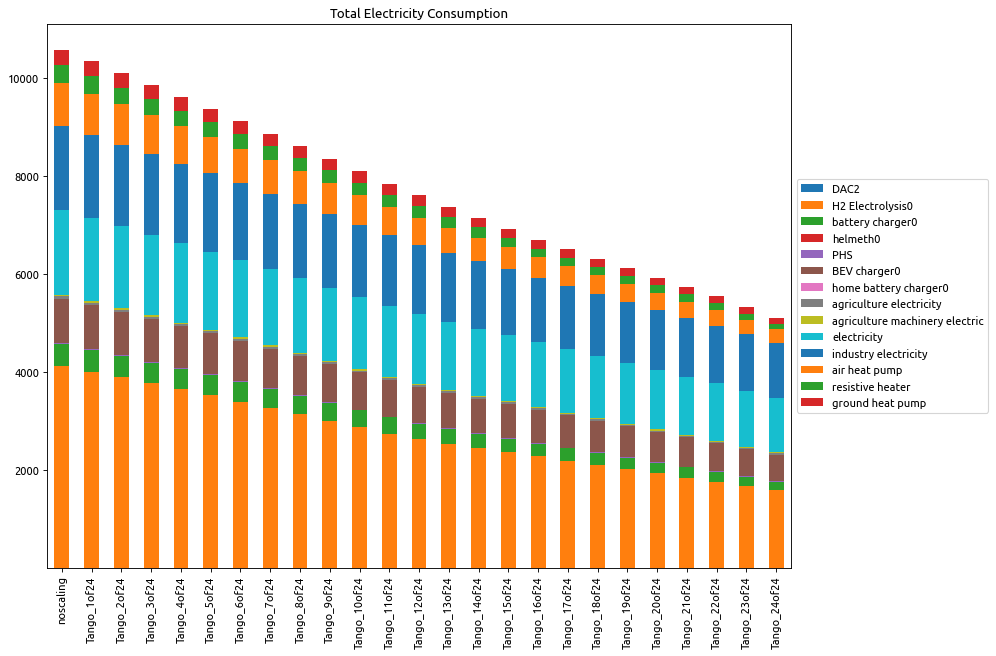

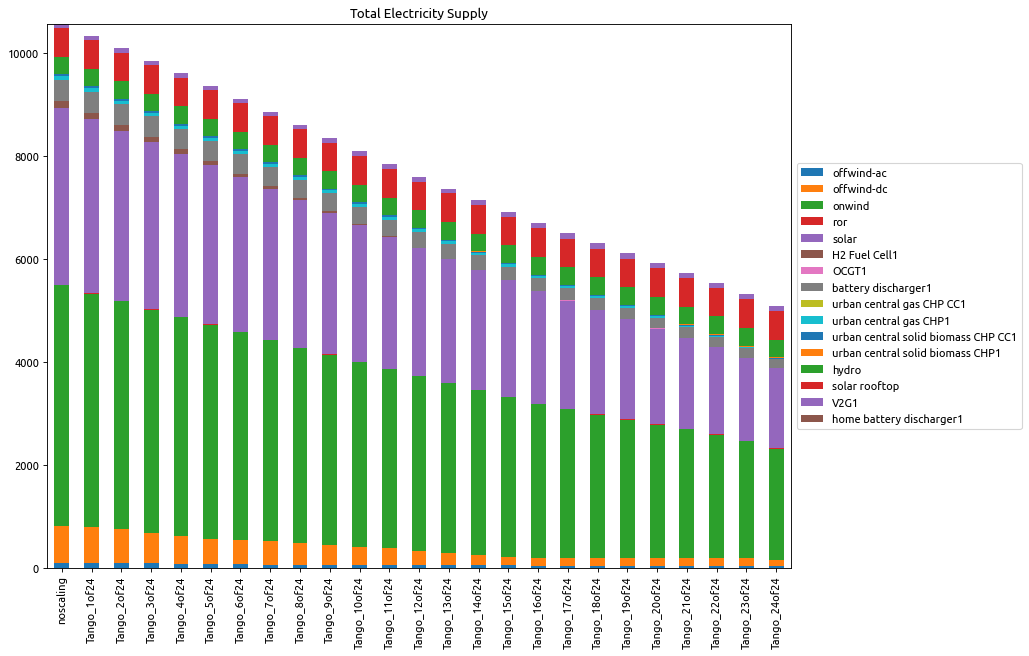

In [42]:
## Electricity Supply and Demand

elec_all = load_data("supply_energy").loc[["AC","low voltage"]]

elec_d = elec_all.loc[[i for i in elec_all.index if elec_all.loc[i]['noscaling']<0]]*-1
elec_d = elec_d.droplevel(["scale","Unnamed: 1"])

elec_s = elec_all.loc[[i for i in elec_all.index if elec_all.loc[i]['noscaling']>0]]
elec_s = elec_s.droplevel(["scale","Unnamed: 1"])


heat_sources = ['air heat pump','resistive heater','ground heat pump']
elec_d = aggregate_heat(elec_d,heat_sources)
elec_d.drop(["electricity distribution grid0","AC1","DC1"],inplace=True) # false variables
elec_d = elec_d/1e6 # convert to TWh

elec_s = elec_s/1e6 # convert to TWh
elec_s.drop(["electricity distribution grid1","AC0","DC0"],inplace=True) # false variable


f1 = plt.figure(figsize=(12, 9), dpi=80)
plt.title('Total Electricity Consumption', color='black')
elec_d.T.plot(kind='bar', stacked=True, ax=f1.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
#ax = elec_d.T.plot.bar(stacked=True)

f2 = plt.figure(figsize=(12, 9), dpi=80)
plt.title('Total Electricity Supply', color='black')
elec_s.T.plot(kind='bar', stacked=True, ax=f2.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


In [144]:
#loads.df.carrier.unique()
#[n for n in nets if any(m in n for m in ["transport","noscaling"])]
tfec_carrier[[c for c in tfec_carrier.columns if "noscaling" in c]]

NameError: name 'tfec_carrier' is not defined

In [147]:
tfec_sector_norm

,noscalings,Tango10of24,Tango11of24,Tango12of24,Tango13of24,Tango14of24,Tango15of24,Tango16of24,Tango17of24,Tango18of24,...,Tango23of24,Tango24of24,Tango2of24,Tango3of24,Tango4of24,Tango5of24,Tango6of24,Tango7of24,Tango8of24,Tango9of24
other elec,1.0,0.854009,0.839410,0.824810,0.810211,0.795612,0.781013,0.766414,0.751815,0.737216,...,0.664220,0.649621,0.970802,0.956203,0.941603,0.927004,0.912405,0.897806,0.883207,0.868608
transport,1.0,0.796465,0.776112,0.755759,0.735405,0.715052,0.694698,0.674345,0.653991,0.633638,...,0.531871,0.511517,0.959293,0.938940,0.918586,0.898233,0.877879,0.857526,0.837172,0.816819
heat,1.0,0.758947,0.734841,0.710736,0.686631,0.662525,0.638420,0.614315,0.590209,0.566104,...,0.445578,0.421472,0.951789,0.927684,0.903579,0.879473,0.855368,0.831263,0.807157,0.783052
industry,1.0,0.821572,0.803730,0.785887,0.768044,0.750201,0.732359,0.714516,0.696673,0.678830,...,0.589616,0.571774,0.964314,0.946472,0.928629,0.910786,0.892943,0.875101,0.857258,0.839415
bunkers,1.0,0.912654,0.903919,0.895185,0.886450,0.877716,0.868981,0.860247,0.851512,0.842777,...,0.799104,0.790370,0.982531,0.973796,0.965062,0.956327,0.947592,0.938858,0.930123,0.921389
ag,1.0,0.792828,0.772111,0.751393,0.730676,0.709959,0.689242,0.668524,0.647807,0.627090,...,0.523504,0.502787,0.958566,0.937848,0.917131,0.896414,0.875697,0.854979,0.834262,0.813545
total,1.0,0.810730,0.791804,0.772877,0.753950,0.735023,0.716096,0.697169,0.678242,0.659315,...,0.564680,0.545753,0.962146,0.943219,0.924292,0.905365,0.886438,0.867511,0.848584,0.829657


# PLOTS

In [43]:
# code taken from plot_summary.py, for correct colors

# color=[snakemake.config['plotting']['tech_colors'][i] for i in new_index]
import yaml

configdir = 'results/'+run_name+'/configs/'
#config = yaml.safe_load()
with open(configdir+"config.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

config['plotting']['tech_colors']['AC']='b'
config['plotting']['tech_colors']['DC']='r'
config['plotting']['tech_colors']['electricity distribution grid']='k'
    
preferred_order = pd.Index([
    "transmission lines",
    "hydroelectricity",
    "hydro reservoir",
    "run of river",
    "pumped hydro storage",
    "solid biomass",
    "biogas",
    "onshore wind",
    "offshore wind",
    "offshore wind (AC)",
    "offshore wind (DC)",
    "solar PV",
    "solar thermal",
    "solar rooftop",
    "solar",
    "building retrofitting",
    "ground heat pump",
    "air heat pump",
    "heat pump",
    "resistive heater",
    "power-to-heat",
    "gas-to-power/heat",
    "CHP",
    "OCGT",
    "gas boiler",
    "gas",
    "natural gas",
    "helmeth",
    "methanation",
    "hydrogen storage",
    "power-to-gas",
    "power-to-liquid",
    "battery storage",
    "hot water storage",
    "CO2 sequestration"
])

def make_new_index(index):
    return preferred_order.intersection(index).append(index.difference(preferred_order))    


In [44]:
#tfec = tfec_sector_norm
#tfec=tfec.T.sort_values('total',ascending=False).T

In [45]:
#caps.loc['generators']

In [46]:
# Graph showing total capcities installed vs TFEC

cost = pd.read_csv(csvdir+outdir+"total_costs.csv",index_col=0)

caps = load_data("capacities")#pd.read_csv(csvdir+"capacities.csv",index_col=[0,1],skiprows=lambda x: x in [0,1,2,4])
caps.drop(('stores','oil'),axis=0,inplace=True)

#caps.loc["stores"].loc["gas"] = caps.loc["stores"].loc["gas"] + caps.loc["generators"].loc["gas"]
#caps.drop(('generators','gas'),axis=0,inplace=True)

caps=caps.droplevel(0)
#caps.index
caps = caps.drop([i for i in caps.index if " water tanks " in i])
caps=aggregate_heat(caps,['solar thermal','gas boiler','resistive heater','air heat pump','water tanks','ground heat pump'])
caps = caps.divide(caps['noscaling'],axis=0)
#caps.index
caps.to_csv(csvdir+outdir+"capacities_agg_normed.csv")


In [47]:
caps.columns
#tfec[pd.Series(caps.columns)]

Index(['noscaling', 'Tango_1of24', 'Tango_2of24', 'Tango_3of24', 'Tango_4of24',
       'Tango_5of24', 'Tango_6of24', 'Tango_7of24', 'Tango_8of24',
       'Tango_9of24', 'Tango_10of24', 'Tango_11of24', 'Tango_12of24',
       'Tango_13of24', 'Tango_14of24', 'Tango_15of24', 'Tango_16of24',
       'Tango_17of24', 'Tango_18of24', 'Tango_19of24', 'Tango_20of24',
       'Tango_21of24', 'Tango_22of24', 'Tango_23of24', 'Tango_24of24'],
      dtype='object')

In [48]:
maxdiff = max(1-tfec.loc['total'])
#maxdiff = 0.4
spacing =maxdiff/5
if spacing < 0.02:
    spacing = 0.01
elif spacing < 0.05:
    spacing = 0.02
elif spacing < 0.1:
    spacing = 0.05
else:
    spacing = 0.1
    
xt = pd.Series(np.arange(0,maxdiff,spacing))

xt


0    0.00
1    0.05
2    0.10
3    0.15
4    0.20
5    0.25
6    0.30
7    0.35
8    0.40
9    0.45
dtype: float64

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



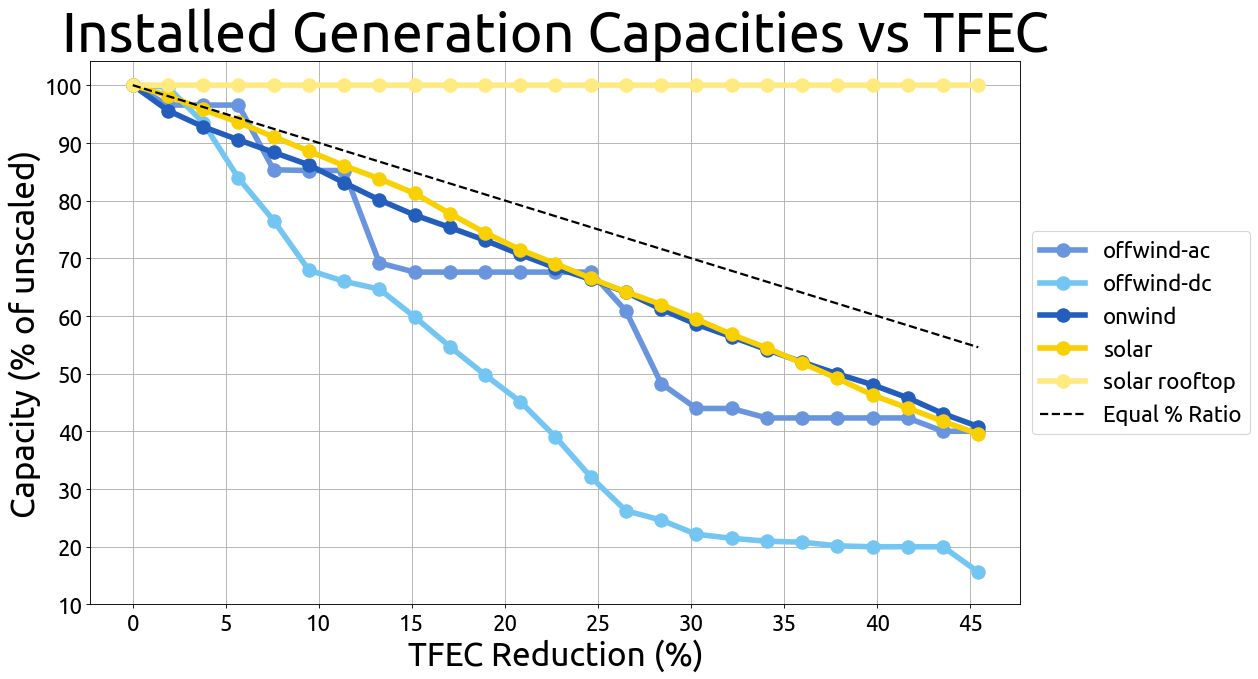

In [49]:
f3, ax = plt.subplots(figsize=(15, 9), dpi=80)

gentechs = [
                'offwind-ac',
                'offwind-dc',
                'onwind',
                'solar',
                'solar rooftop'
            ]
heattechs = [
                'solar thermal',
                'gas boiler',
                'air heat pump',
                'ground heat pump',
                'resistive heater'
            ]
storetechs = [
                'battery',
                'home battery',
                'water tanks'
            ]
h2techs = [
            'H2 Electrolysis',
            'H2 pipeline'
            ]

fueltechs = [
            'oil',
            'gas',
            'biogas',
            'solid biomass'
            ]

transtechs = [
                'AC',
                'DC',
                'electricity distribution grid',
                'H2 pipeline'
              ]

chemtechs = [
            'Fischer-Tropsch',
            'H2 Electrolysis',
            'Sabatier',
            #'',
            #'',
            #'',
            ]

for t in gentechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[gentechs]))),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)


#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])


ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Generation Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(visible=True)

f3.savefig(figdir+'gen.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



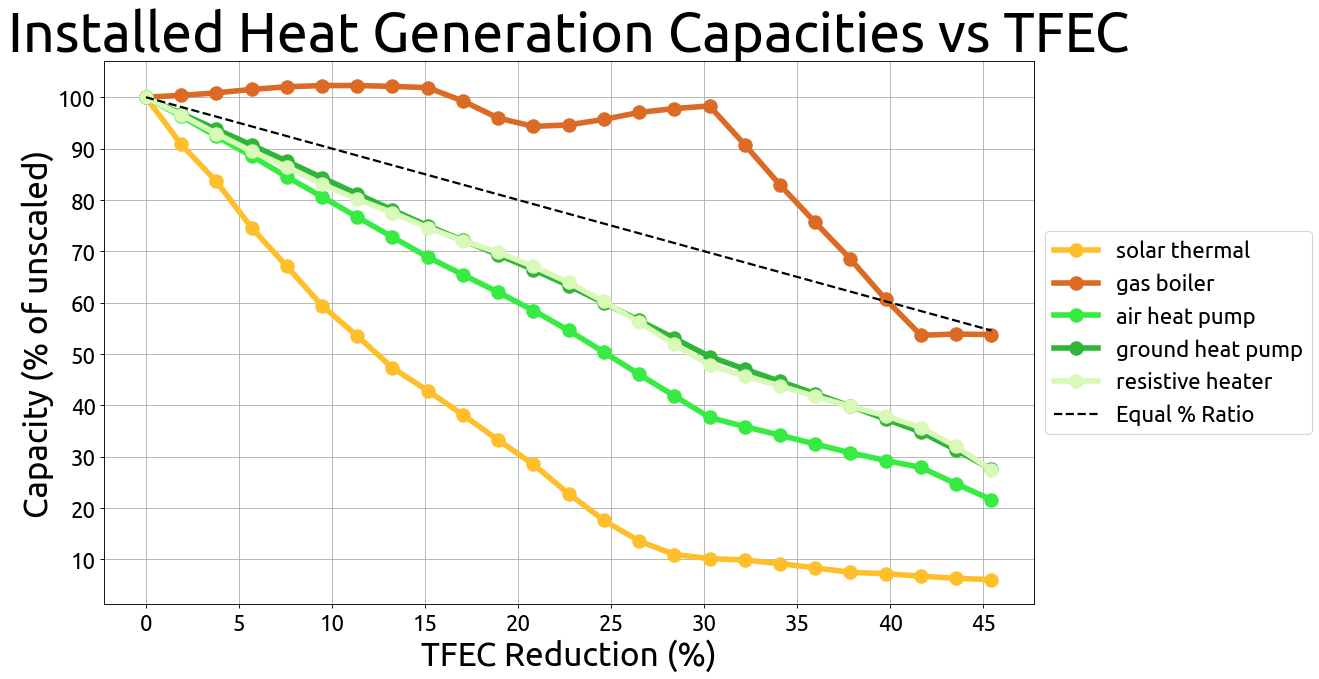

In [50]:
f4, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in heattechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[heattechs])),1),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Heat Generation Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f4.savefig(figdir+'heat.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



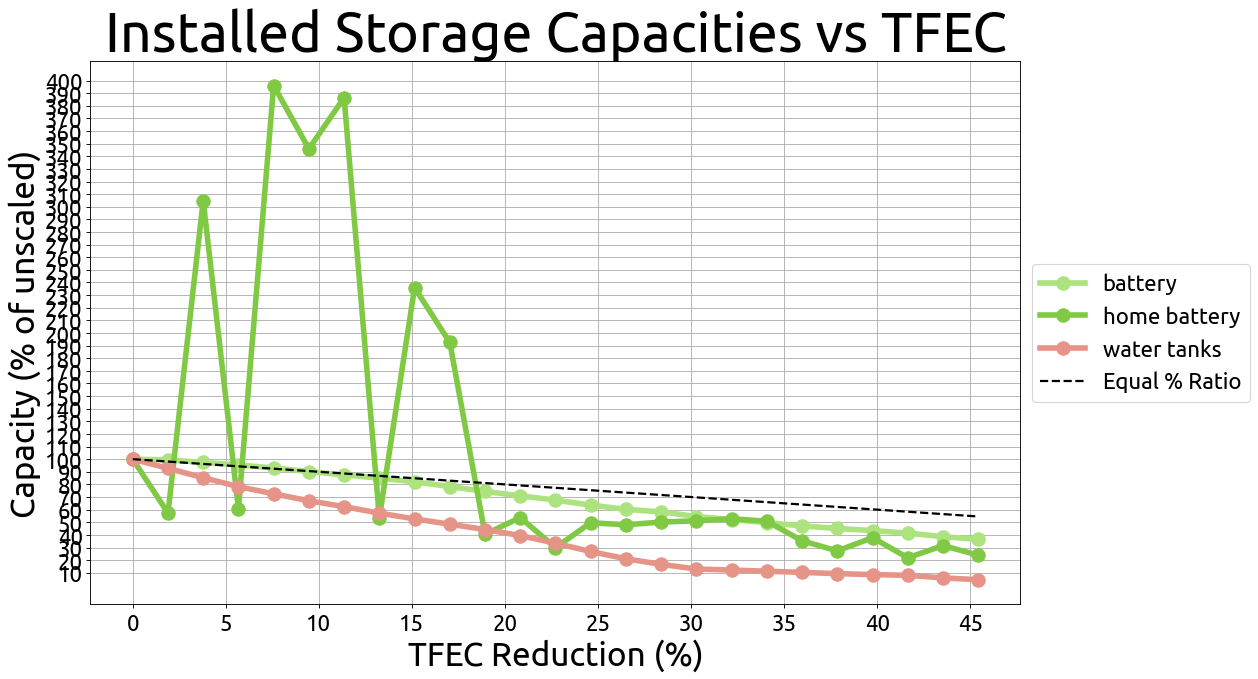

In [51]:
f5, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in storetechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[storetechs]))),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Storage Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f5.savefig(figdir+'store.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



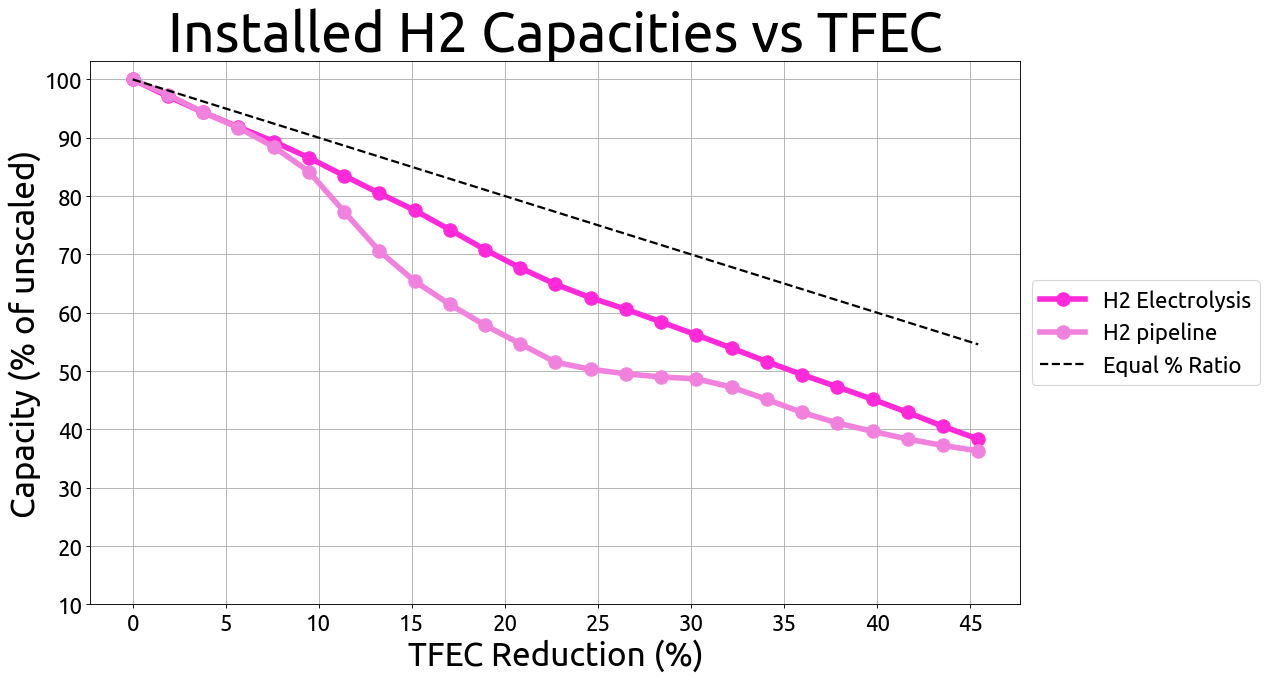

In [52]:
f6, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in h2techs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[h2techs]))),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed H2 Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f6.savefig(figdir+'h2.png', bbox_inches='tight')

In [54]:
fueltechs

['oil', 'gas', 'biogas', 'solid biomass']

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



KeyboardInterrupt: 

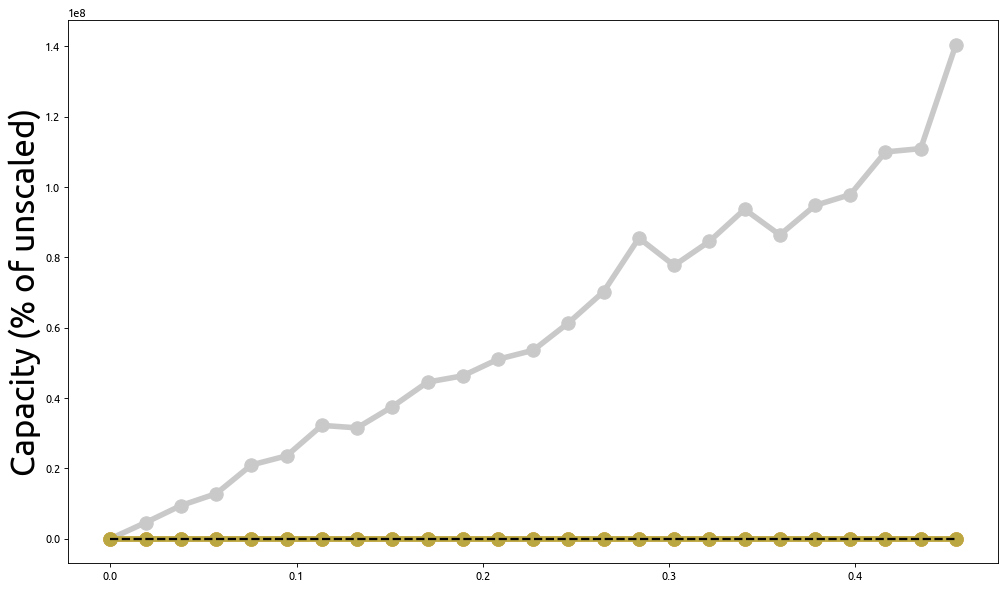

In [53]:
f7, ax = plt.subplots(figsize=(15, 9), dpi=80)

for t in fueltechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[fueltechs])),1),0,-0.25))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Fuel Use vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f7.savefig(figdir+'fuel.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



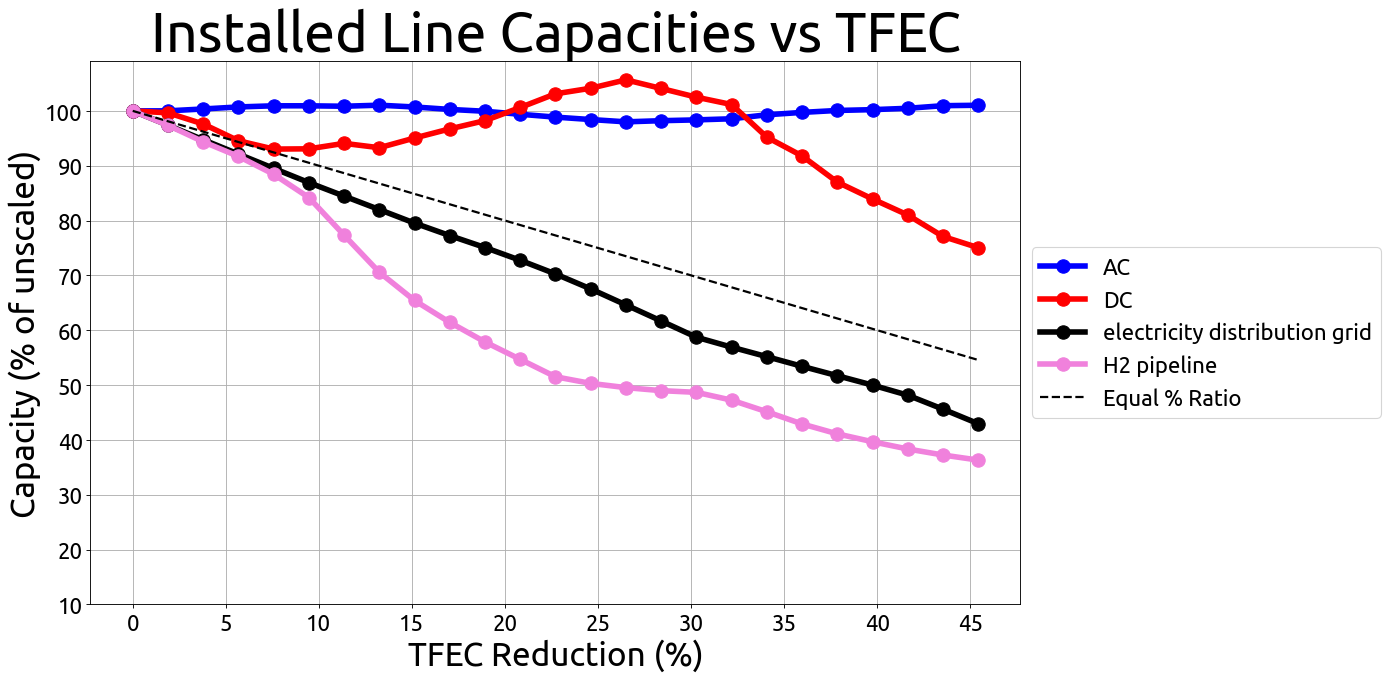

In [55]:
f8, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in transtechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[transtechs]))),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Line Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f8.savefig(figdir+'t_and_d.png', bbox_inches='tight')

/home/poweruser/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



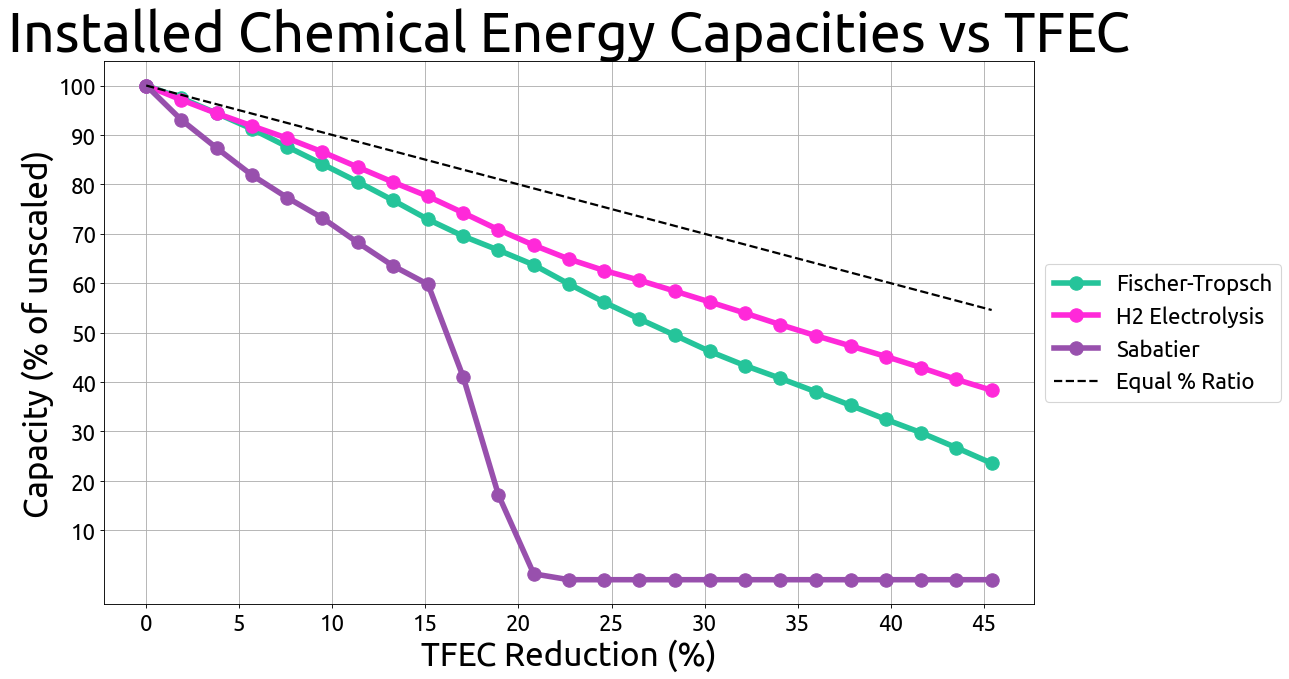

In [56]:
f9, ax = plt.subplots(figsize=(15, 9), dpi=80)


for t in chemtechs:
    ax.plot(1-tfec.loc['total'],caps.loc[t],'o-', color = config['plotting']['tech_colors'][t], label=t, linewidth=5,markersize=12)

ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

ax.set_ylabel('Capacity (% of unscaled)', fontsize=30)
yt = pd.Series(np.arange(np.round_(np.max(np.max(caps.loc[chemtechs])),1),0,-0.1))
ax.set_yticks(yt, np.round_((100*yt)).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Installed Chemical Energy Capacities vs TFEC', fontsize=50)
ax.legend(prop={'size': 20},loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.grid(visible=True)

f9.savefig(figdir+'chem.png', bbox_inches='tight')

In [61]:
cost = pd.read_csv(csvdir+outdir+"total_costs.csv",index_col=0)
cost['ratio']
tfec

,noscalings
elec,1.0
h2,1.0
heat,1.0
fuels,1.0
total,1.0


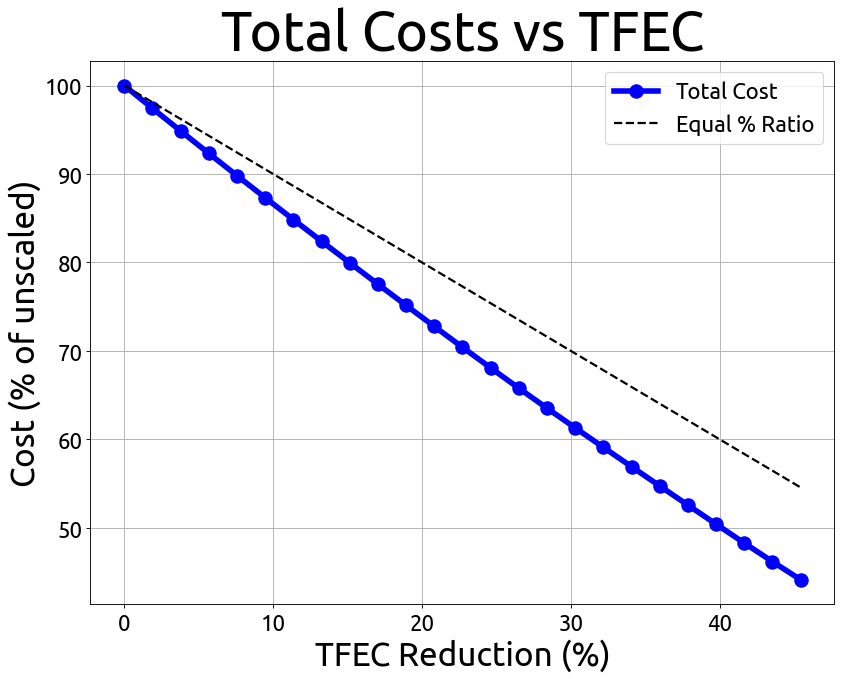

In [64]:
# Graph showing total costs vs TFEC

cost = pd.read_csv(csvdir+outdir+"total_costs.csv",index_col=0)
tfec = get_tfec()

fc, ax = plt.subplots(figsize=(12, 9), dpi=80)
#f3 = plt.figure(figsize=(12, 9), dpi=80)
ax.set_title('Total Costs vs TFEC', color='black')
#elec_s.T.plot(kind='bar', stacked=True, ax=f2.gca())

ax.plot(1-tfec.loc['total'],cost['ratio'],'bo-', label='Total Cost', linewidth=5,markersize=12)
ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

#ax.set(title='Total Costs vs TFEC', xlabel='Total Costs vs TFEC', ylabel='Total System Costs (% of unscaled system)');

ax.set_ylabel('Cost (% of unscaled)', fontsize=30)
yt = pd.Series([1,0.9,0.8,0.7,0.6,0.5])
ax.set_yticks(yt, (100*yt).astype(int),fontsize=20)


ax.set_xlabel('TFEC Reduction (%)', fontsize=30)
xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)

ax.set_title('Total Costs vs TFEC', fontsize=50)
ax.legend(prop={'size': 20})
ax.grid(visible=True)



#fig.legend(['Total Cost','Equal % Change'],loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.show()
fc.savefig(figdir+'costs.png', bbox_inches='tight')


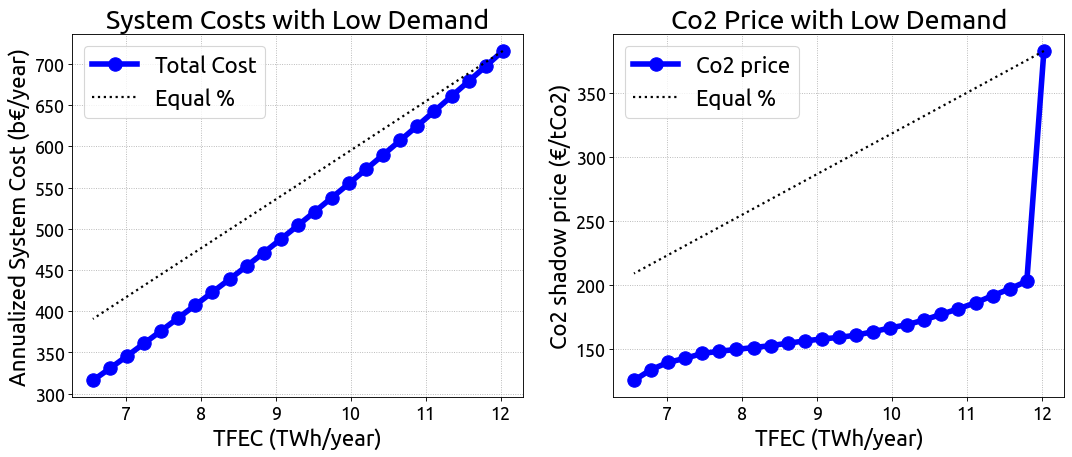

In [77]:
# Graph showing total costs vs TFEC

titlesize = 24 
ticksize  = 16
axissize  = 20

cost = pd.read_csv(csvdir+outdir+"total_costs.csv",index_col=0)
tfec = get_tfec()

fc, axs = plt.subplots(1,2,figsize=(16, 6), dpi=80)
ax = axs[0]
#f3 = plt.figure(figsize=(12, 9), dpi=80)
#elec_s.T.plot(kind='bar', stacked=True, ax=f2.gca())

ax.plot(tfec.loc['all']/1e9,cost['total']/1e9,'bo-', label='Total Cost', linewidth=5,markersize=12)
ax.plot(tfec.loc['all']/1e9,cost['total'].max()/1e9*tfec.loc['all']/tfec.loc['all'].max(),'k:', label='Equal %', linewidth=2,markersize=12)

#ax.set(title='Total Costs vs TFEC', xlabel='Total Costs vs TFEC', ylabel='Total System Costs (% of unscaled system)');

ax.set_ylabel('Annualized System Cost (b€/year)', fontsize=axissize)
#yt = pd.Series([1,0.9,0.8,0.7,0.6,0.5])
#ax.set_yticks(yt, (100*yt).astype(int),fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=ticksize)


ax.set_xlabel('TFEC (TWh/year)', fontsize=axissize)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
#ax.set_xticks(xt, (100*xt).astype(int),fontsize=20)
plt.setp(ax.get_xticklabels(), fontsize=ticksize)

ax.set_title('System Costs with Low Demand', fontsize=titlesize)
ax.legend(prop={'size': axissize})
ax.grid(visible=True,linestyle=":")



#fig.legend(['Total Cost','Equal % Change'],loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.show()
fc.savefig(figdir+'costs.png', bbox_inches='tight')
######################################################################################################################

tfec = get_tfec()

#fco2, axs = plt.subplots(1,2, figsize=(12, 9), dpi=80)
ax = axs[1]
#f3 = plt.figure(figsize=(12, 9), dpi=80)
#elec_s.T.plot(kind='bar', stacked=True, ax=f2.gca())

co2p = load_data("prices").loc["co2"]*-1


ax.plot(tfec.loc['all']/1e9,co2p,'bo-', label='Co2 price', linewidth=5,markersize=12)
ax.plot(tfec.loc['all']/1e9,co2p.max()*tfec.loc['all']/tfec.loc['all'].max(),'k:', label='Equal %', linewidth=2,markersize=12)

#ax.plot(1-tfec.loc['total'],tfec.loc['total'],'k--', label='Equal % Ratio', linewidth=2)

#ax.set(title='Total Costs vs TFEC', xlabel='Total Costs vs TFEC', ylabel='Total System Costs (% of unscaled system)');

ax.set_ylabel('Co2 shadow price (€/tCo2)', fontsize=axissize)
#yt = pd.Series([1,0.9,0.8,0.7,0.6,0.5])
#ax.set_yticks(np.arange(150,351,50),fontsize=30)
plt.setp(ax.get_yticklabels(), fontsize=ticksize)



ax.set_xlabel('TFEC (TWh/year)', fontsize=axissize)
#xt = pd.Series([0.0,0.1,0.2,0.3,0.4])
#ax.set_xticks(np.arange(7000,12001,1000),fontsize=ticksize)
#ax.set_xticks(np.arange(7000,12001,1000),fontsize=ticksize)

plt.setp(ax.get_xticklabels(), fontsize=ticksize)



ax.set_title('Co2 Price with Low Demand', fontsize=titlesize)
ax.legend(prop={'size': axissize})
#ax.grid(visible=True)



#fig.legend(['Total Cost','Equal % Change'],loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.show()

ax.set_axisbelow(True)
ax.grid(visible=True,linestyle=":")

fc.savefig(figdir+'costs+co2price.png', bbox_inches='tight')

In [69]:
co2p

noscaling       382.653985
Tango_1of24     202.805880
Tango_2of24     196.797574
Tango_3of24     191.503053
Tango_4of24     185.951138
Tango_5of24     181.320444
Tango_6of24     176.964398
Tango_7of24     172.614356
Tango_8of24     168.838709
Tango_9of24     166.335480
Tango_10of24    163.310024
Tango_11of24    160.662453
Tango_12of24    158.854466
Tango_13of24    157.690024
Tango_14of24    156.115273
Tango_15of24    154.339016
Tango_16of24    152.452103
Tango_17of24    150.988040
Tango_18of24    149.489648
Tango_19of24    148.099795
Tango_20of24    146.336286
Tango_21of24    142.596220
Tango_22of24    139.365085
Tango_23of24    133.731145
Tango_24of24    125.296672
Name: co2, dtype: float64

# NODAL ANALYSIS

In [955]:
# Graph showing total capcities installed vs TFEC

ncaps = pd.read_csv(csvdir+"nodal_capacities.csv",index_col=[0,1,2],skiprows=lambda x: x in [0,1,2,4])
ncaps

#ncaps.drop(('stores','oil'),axis=0,inplace=True)
ncaps=ncaps.droplevel(0)
#caps.index
ncaps = ncaps.drop([i for i in caps.index if " water tanks " in i])
#ncaps=aggregate_heat(caps,['solar thermal','gas boiler','resistive heater','air heat pump','water tanks','ground heat pump'])
ncaps = ncaps.divide(ncaps['noscaling'],axis=0)
#caps.index



ncaps.index = ncaps.index.swaplevel()
ncaps=ncaps.sort_index(level=0)
ncaps.to_csv(csvdir+outdir+"capacities_nodal_agg_normed.csv")

ncaps

noscaling  Tango_1of10  \
AC                                   NaN          1.0     0.946322   
BEV charger                          AL1 0        1.0     1.000000   
                                     AT1 0        1.0     1.000000   
                                     BA1 0        1.0     1.000000   
                                     BE1 0        1.0     1.000000   
...                                               ...          ...   
urban central water tanks discharger RO1 0        1.0     0.552756   
                                     RS1 0        1.0     0.659676   
                                     SE2 0        1.0     0.894228   
                                     SI1 0        1.0     0.849192   
                                     SK1 0        1.0     0.733055   

                                            Tango_2of10  Tango_3of10  \
AC                                   NaN       0.905855     0.829550   
BEV charger                          AL1 0     1.000000     1.000000   
                                     AT1 0     1.000000     1.000000   
                                     BA1 0     1.000000     1.000000   
                                     BE1 0     1.000000     1.000000   
...                                                 ...          ...   
urban central water tanks discharger RO1 0     0.582027     0.497726   
                                     RS1 0     0.583919     0.613937   
                                     SE2 0     0.627807     0.407068   
                                     SI1 0     0.784808     0.659456   
                                     SK1 0     0.595778     0.558340   

                                            Tango_4of10  Tango_5of10  \
AC                                   NaN       0.763255     0.702238   
BEV charger                          AL1 0     1.000000     1.000000   
                                     AT1 0     1.000000     1.000000   
                                     BA1 0     1.000000     1.000000   
                                     BE1 0     1.000000     1.000000   
...                                                 ...          ...   
urban central water tanks discharger RO1 0     0.467812     0.426192   
                                     RS1 0     0.612182     0.594021   
                                     SE2 0     0.400476     0.302211   
                                     SI1 0     0.414420     0.371582   
                                     SK1 0     0.406530     0.346002   

                                            Tango_6of10  Tango_7of10  \
AC                                   NaN       0.680675     0.653452   
BEV charger                          AL1 0     1.000000     1.000000   
                                     AT1 0     1.000000     1.000000   
                                     BA1 0     1.000000     1.000000   
                                     BE1 0     1.000000     1.000000   
...                                                 ...          ...   
urban central water tanks discharger RO1 0     0.384570     0.314497   
                                     RS1 0     0.535686     0.472608   
                                     SE2 0     0.275011     0.309162   
                                     SI1 0     0.327441     0.341233   
                                     SK1 0     0.299496     0.275553   

                                            Tango_8of10  Tango_9of10  \
AC                                   NaN       0.626731     0.592349   
BEV charger                          AL1 0     1.000000     1.000000   
                                     AT1 0     1.000000     1.000000   
                                     BA1 0     1.000000     1.000000   
                                     BE1 0     1.000000     1.000000   
...                                                 ...          ...   
urban central water tanks discharger RO1 0     0.146286     0.125992   
                                

In [964]:
elec_d

,noscaling,Tango_1of10,Tango_2of10,Tango_3of10,Tango_4of10,Tango_5of10,Tango_6of10,Tango_7of10,Tango_8of10,Tango_9of10,Tango_10of10
H2 Electrolysis0,3741.309735,3507.269450,3300.246959,3141.143488,2909.795530,2703.677265,2499.918955,2283.039407,2030.182285,1735.970259,1483.271334
battery charger0,0.006509,0.005143,0.004212,0.004281,0.004076,0.002267,0.002736,0.002278,0.002417,0.002568,0.002358
helmeth0,0.000328,0.000238,0.000198,0.000248,0.000214,0.000128,0.000154,0.000123,0.000118,0.000132,0.000093
PHS,4.552645,4.467689,4.375951,3.973825,4.024265,3.720477,3.756136,3.724249,3.507858,3.546719,3.113666
BEV charger0,816.663208,776.861269,736.925918,696.989898,657.117144,617.234848,577.377229,537.528868,497.678129,457.911264,418.094911
home battery charger0,0.005232,0.004144,0.003338,0.003395,0.003260,0.001794,0.002148,0.001795,0.001926,0.002030,0.001891
agriculture electricity,44.861105,42.955552,41.049998,39.144445,37.238891,35.333338,33.427784,31.522231,29.616677,27.711124,25.805571
agriculture machinery electric,37.125395,35.226220,33.327045,31.427870,29.528695,27.629520,25.730345,23.831170,21.931995,20.032819,18.133644
electricity,1720.706142,1660.416203,1600.126265,1539.836326,1479.546387,1419.256449,1358.966510,1298.676571,1238.386633,1178.096694,1117.806755
industry electricity,1721.747131,1661.598396,1601.449661,1541.300926,1481.152191,1421.003456,1360.854722,1300.705987,1240.557252,1180.408517,1120.259782


# Workshop

Gen found


array(['AC', 'co2', 'co2 stored', 'gas', 'H2', 'battery', 'Li ion',
       'residential rural heat', 'residential rural water tanks',
       'services rural heat', 'services rural water tanks',
       'residential urban decentral heat',
       'residential urban decentral water tanks',
       'services urban decentral heat',
       'services urban decentral water tanks', 'urban central heat',
       'urban central water tanks', 'biogas', 'solid biomass',
       'solid biomass for industry', 'gas for industry', 'oil',
       'process emissions', 'low voltage', 'home battery'], dtype=object)

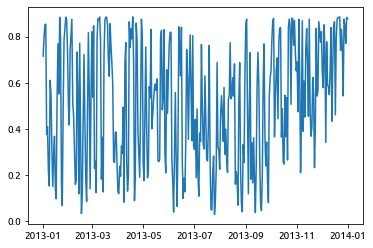

In [27]:
for c in n.iterate_components(n.branch_components|n.controllable_one_port_components):
        if c.name == "Generator":
            print("Gen found")
            gens = c
plt.plot(n.generators_t.p_max_pu["DK1 0 offwind-dc"])


n.buses.carrier.unique()